In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Data

In [2]:
passengers_df = pd.read_csv('data/AIRLINE_PASSENGERS.csv', parse_dates=['Date'])
alcohol_df = pd.read_csv('data/ALCOHOL_SALES.csv', parse_dates=['Date'])
beer_df = pd.read_csv('data/AUS_BEER_PRODUCTION.csv', parse_dates=['Date'])
electric_df = pd.read_csv('data/ELECTRIC_PRODUCTION.csv', parse_dates=['Date'])
minTemp_df = pd.read_csv('data/MIN_TEMP.csv', parse_dates=['Date'])
gdp_df = pd.read_csv('data/NOR_GDP.csv', parse_dates=['Date'])
#population_df = pd.read_csv('data/POPULATION.csv', parse_dates=['Date'])
sunspots_df = pd.read_csv('data/SUNSPOTS.csv', parse_dates=['Date'])
SP_df = pd.read_csv('data/SP.csv', parse_dates=['Date'])
yahoo_df = pd.read_csv('data/YAHOO.csv', parse_dates=['Date'])
tesla_df = pd.read_csv('data/TESLA.csv', parse_dates=['Date'])


dfs_list = []
dfs_list.append(passengers_df)
dfs_list.append(alcohol_df)
dfs_list.append(beer_df)
dfs_list.append(electric_df)
dfs_list.append(minTemp_df)
dfs_list.append(gdp_df)
dfs_list.append(sunspots_df)
dfs_list.append(SP_df)
dfs_list.append(yahoo_df)
dfs_list.append(tesla_df)


def set_name(dfs,names):
    for ind, df in enumerate(dfs):
        df.name = names[ind]
    return dfs
name_list = ['passengers_df', 'alcohol_df', 'beer_df', 
             'electric_df', 'minTemp_df', 'gdp_df', 'sunspots_df','SP_df', 'yahoo_df', 'tesla_df']



dfs_list = set_name(dfs_list, name_list)


# Overview
### Stationarity
- (1) Visualize data with plots (for information)
- (2) Global vs. local tests (Mean and Variance/Standard Deviation)
- (3) Statistical tests for stationarity
- (4) Differencing
- (5) Repeat step 4-5 until stationary
### Recognize Model:

### Model testing:


# Basic Plots

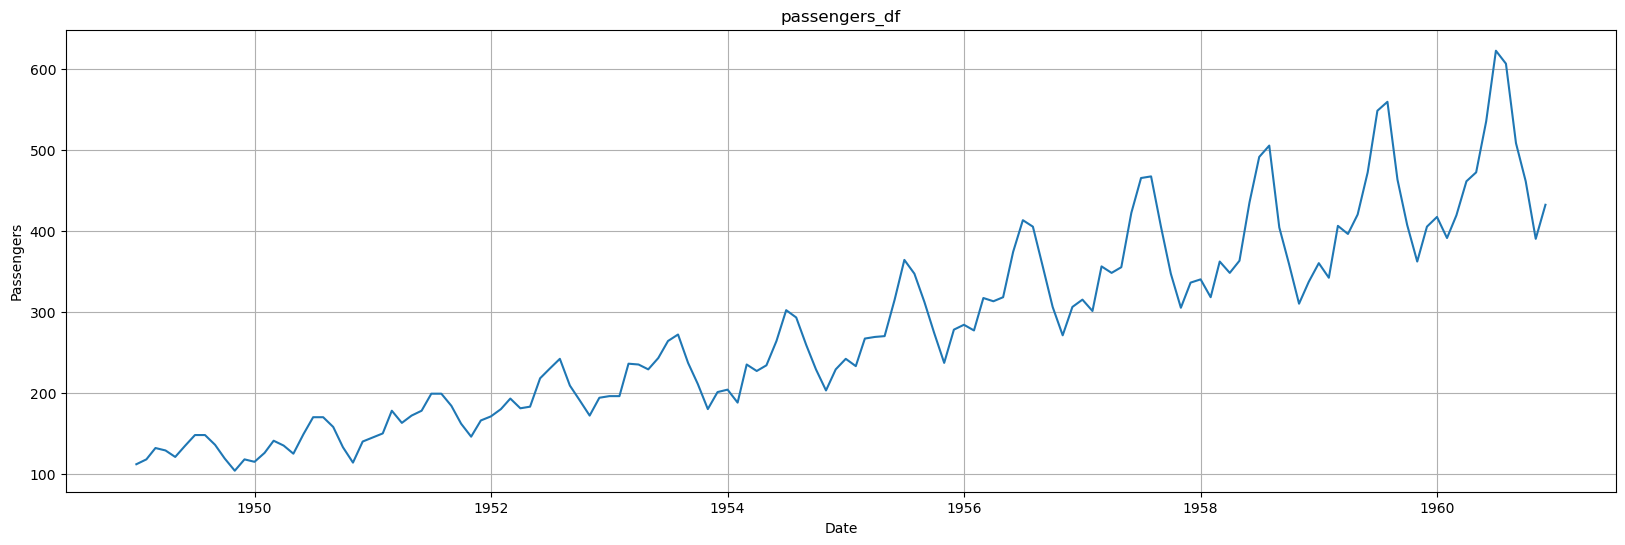

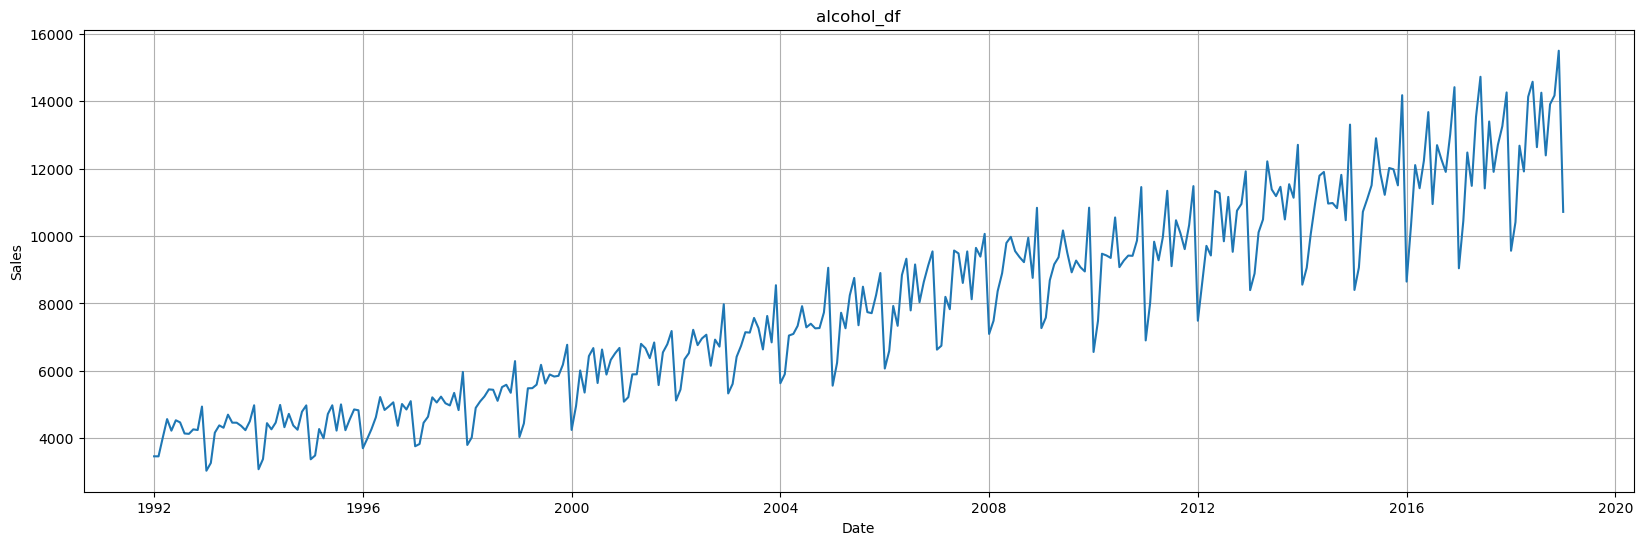

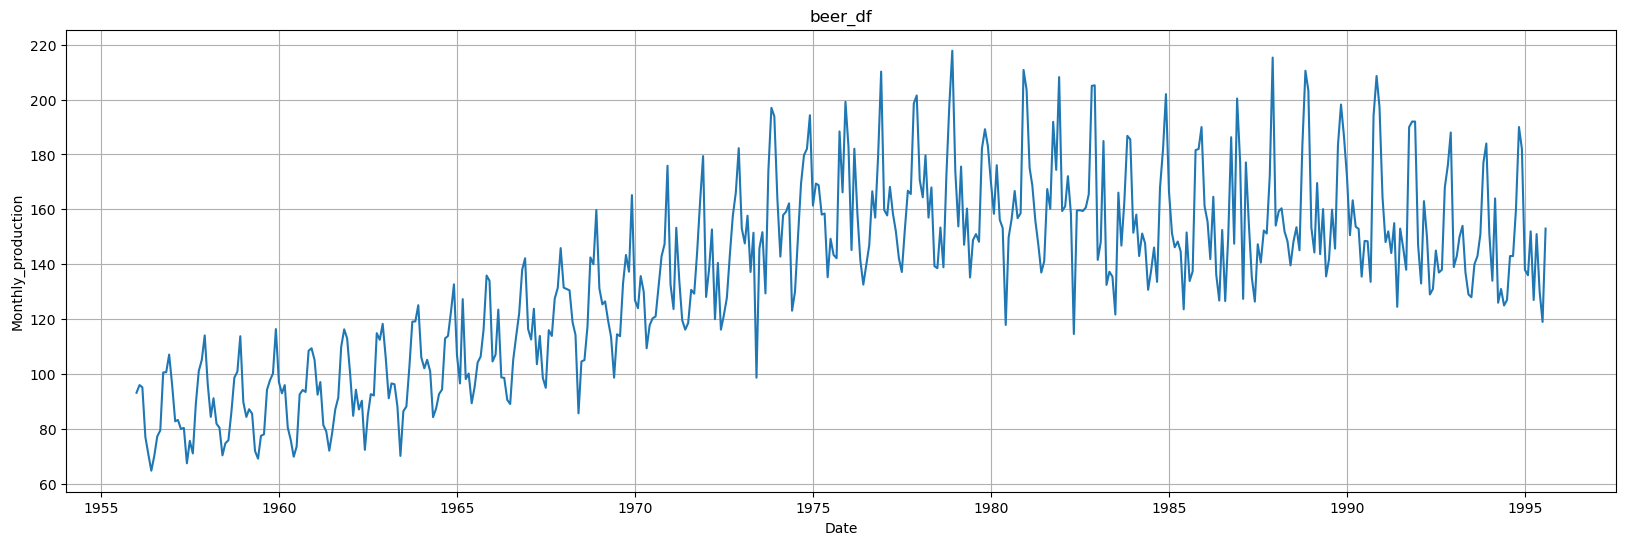

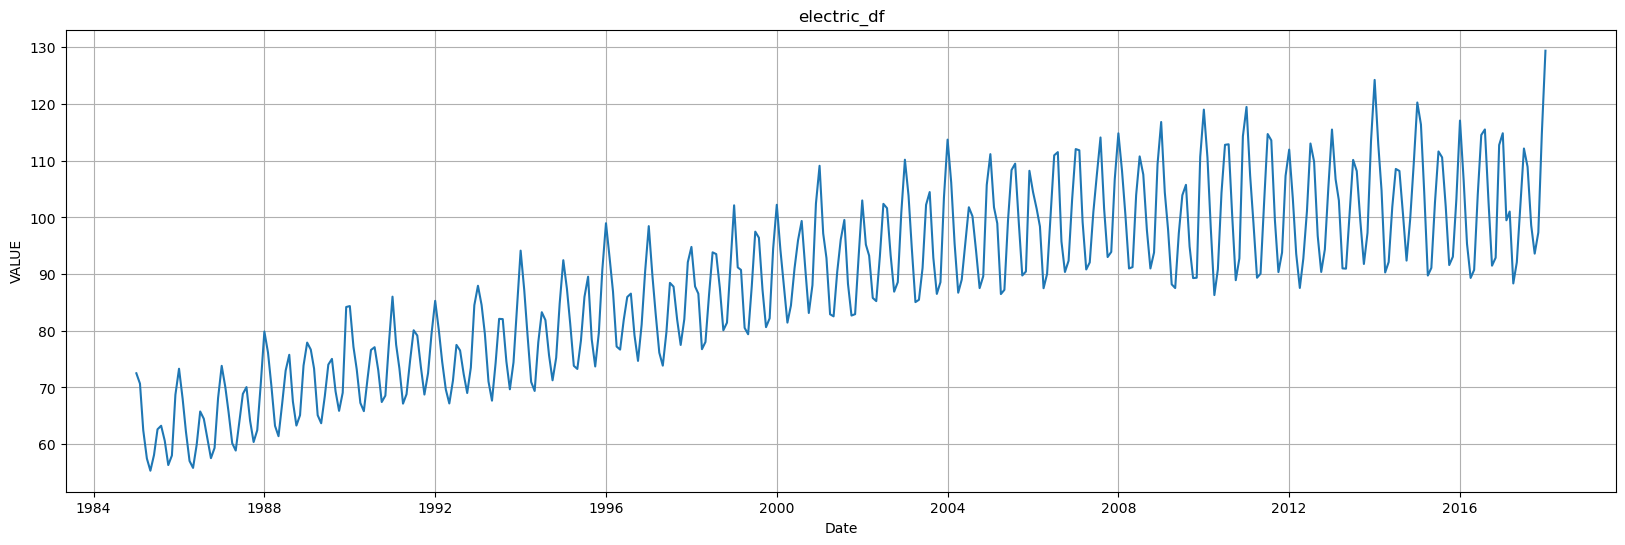

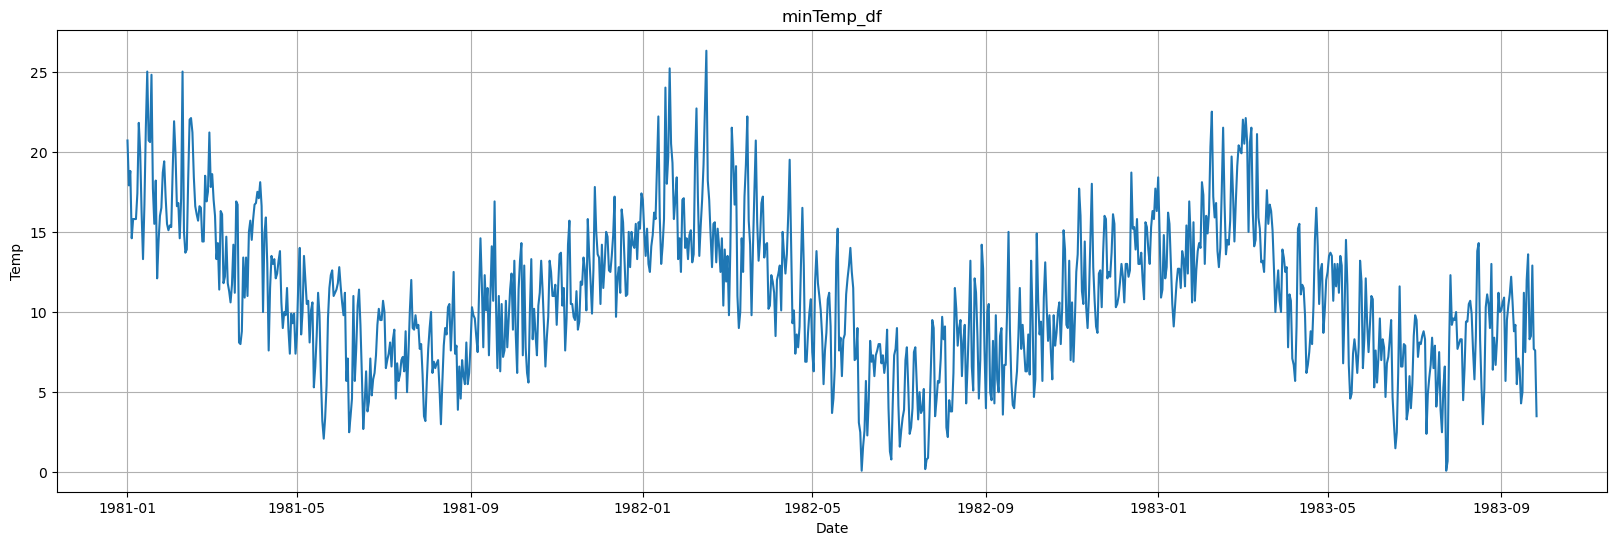

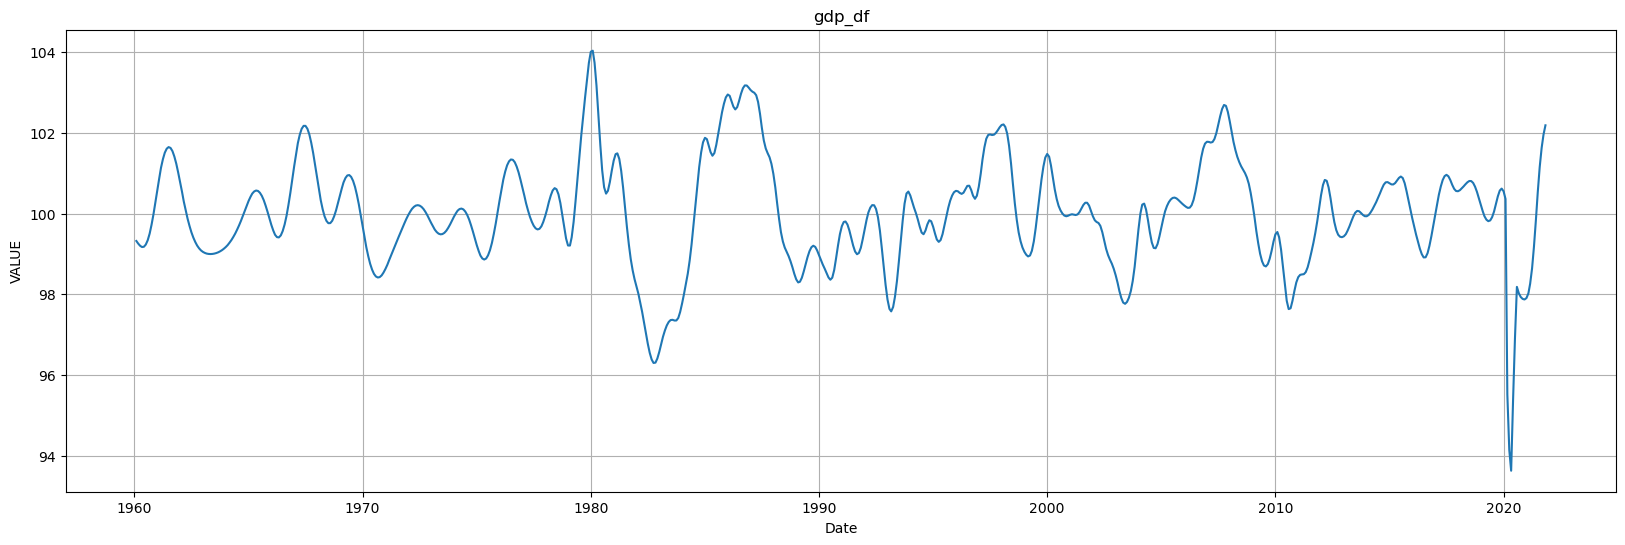

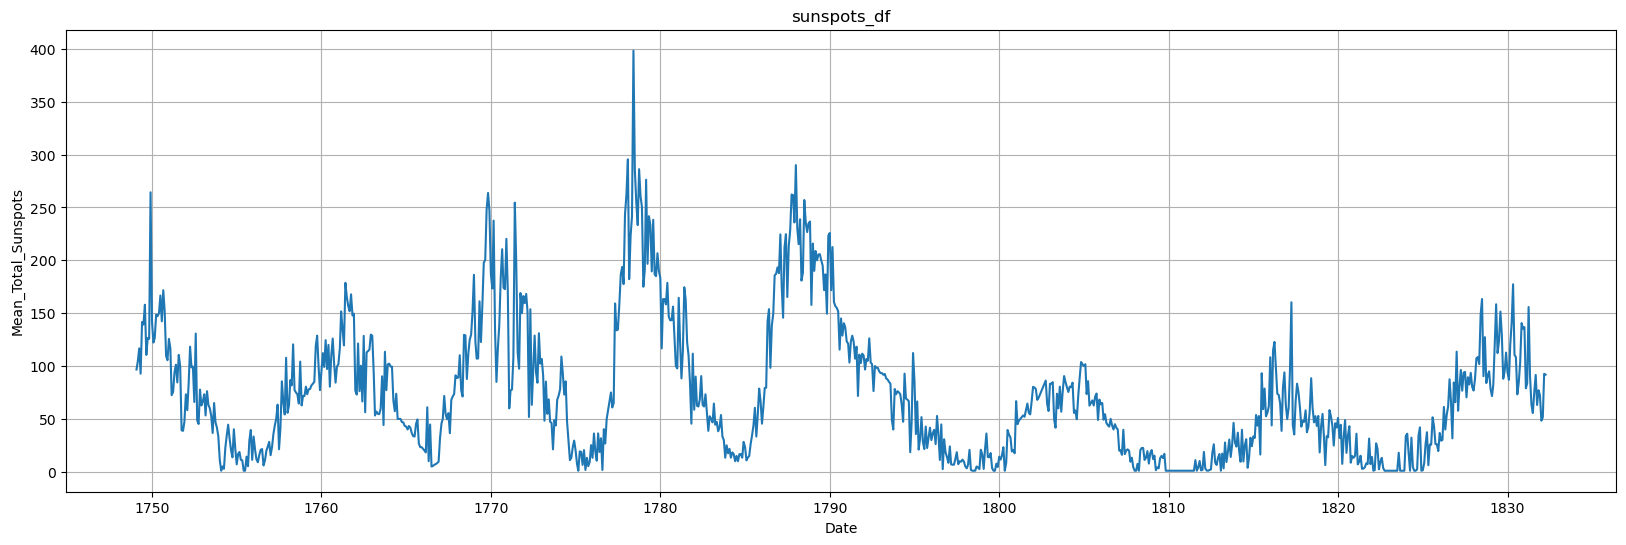

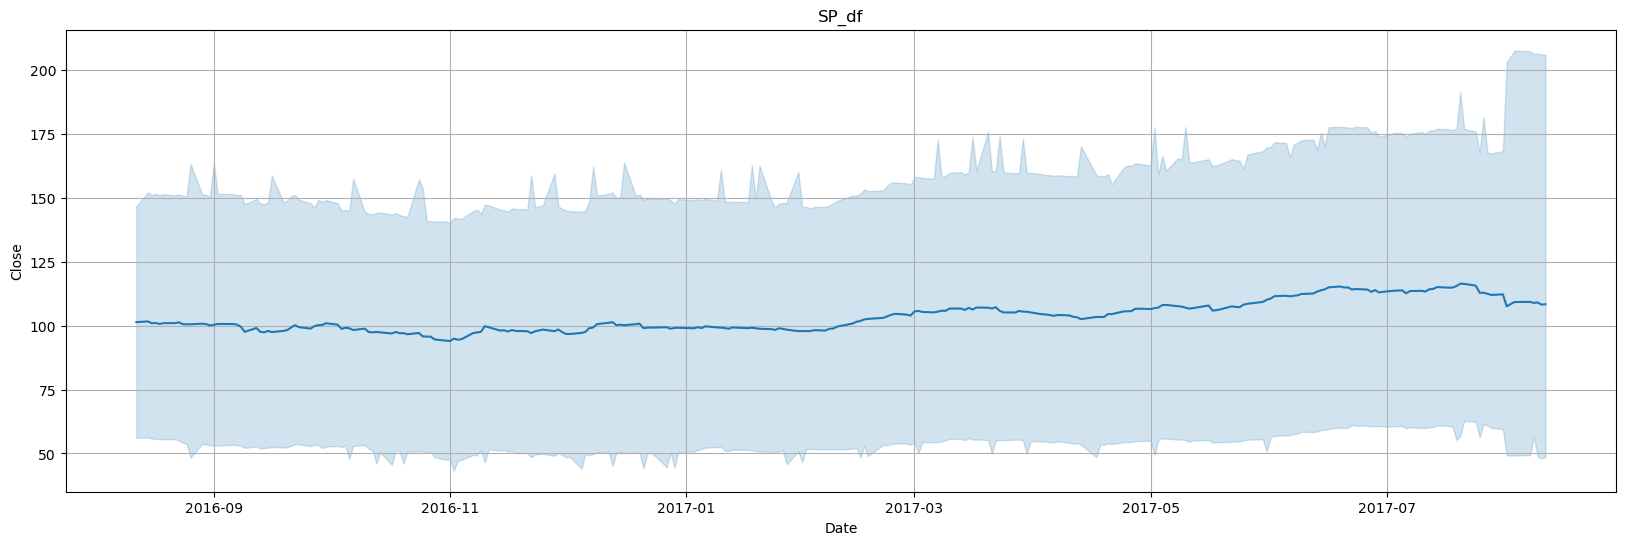

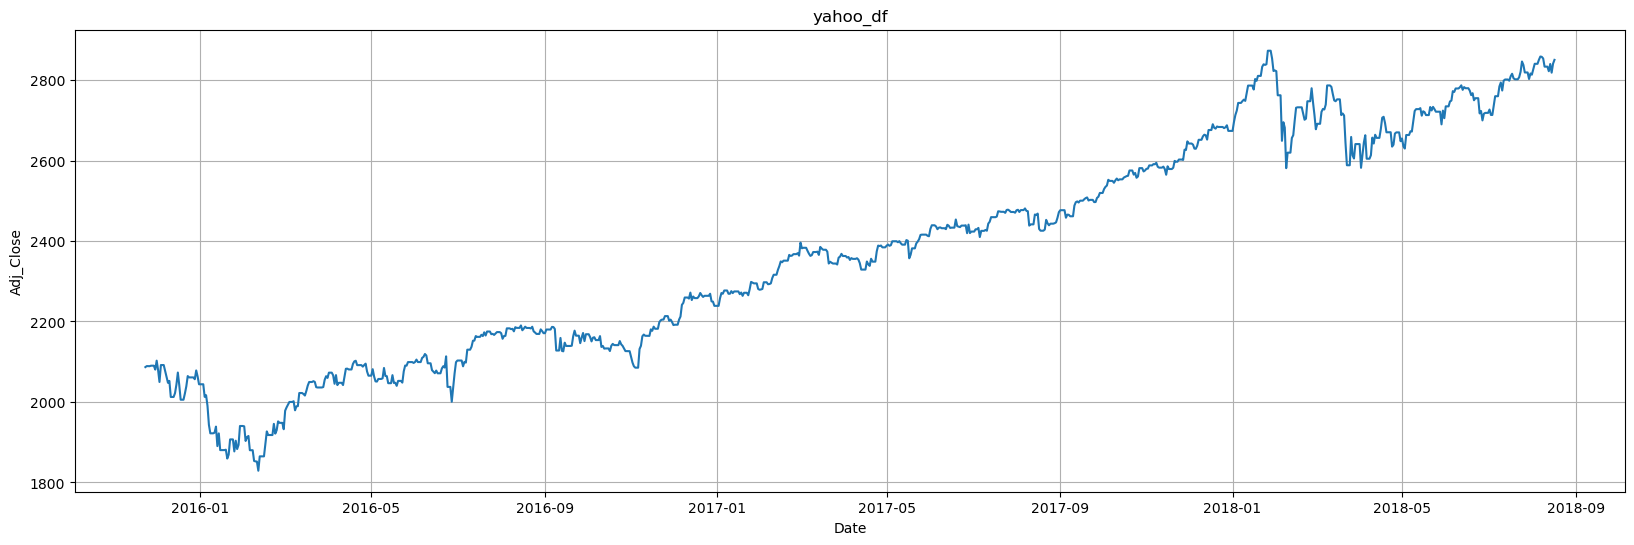

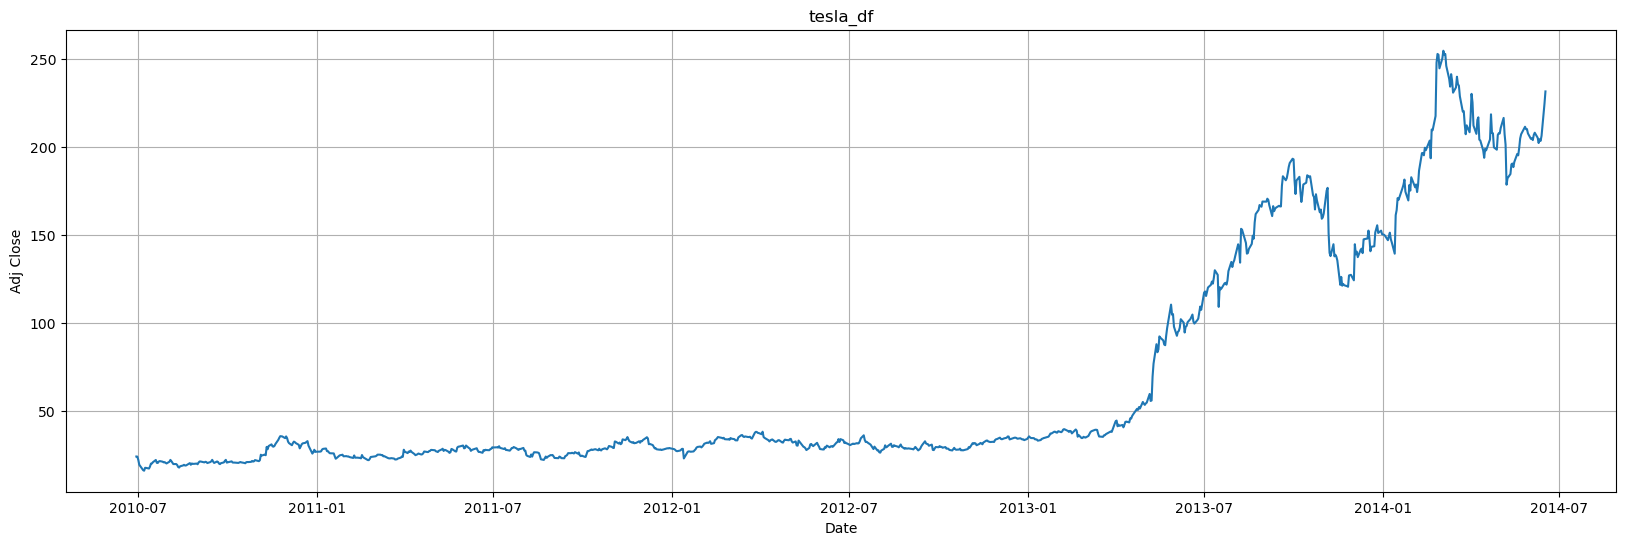

In [3]:
def plot_data(dfs):
    for df in dfs:
        plt.figure(figsize= (20, 6))
        col0 = df.columns[0]
        col1 = df.columns[1]
        sns.lineplot(x= f"{col0}", y=f"{col1}", data  = df)
        plt.title(f'{df.name}')
        plt.grid()
        plt.show()

plot_data(dfs_list)

# Mean and Variance/Standard Deviation

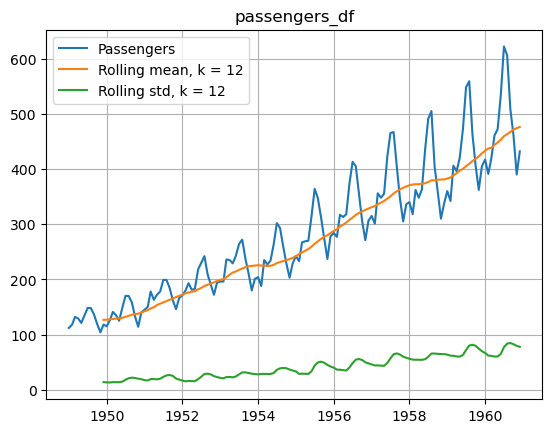

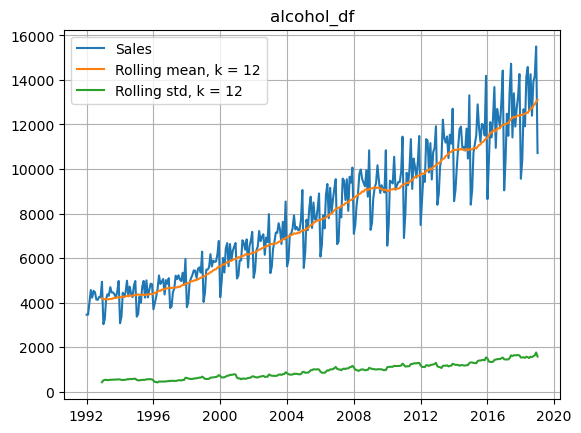

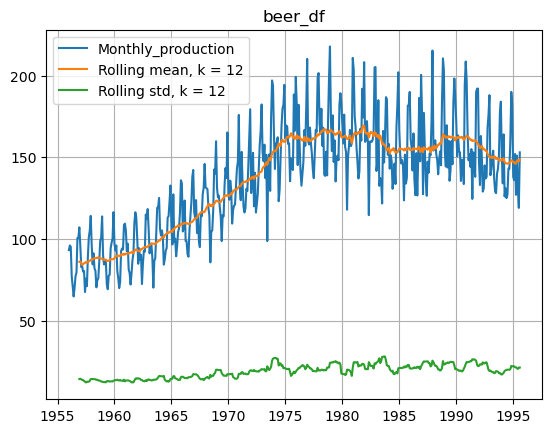

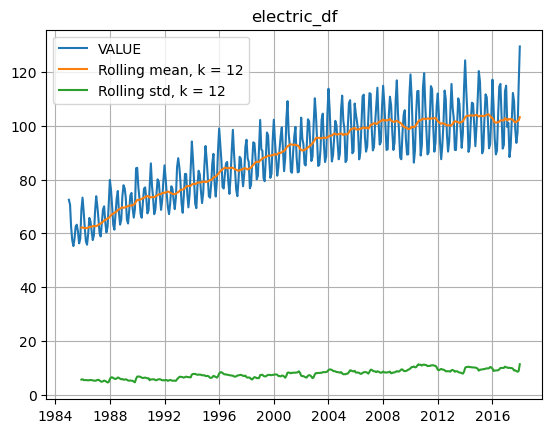

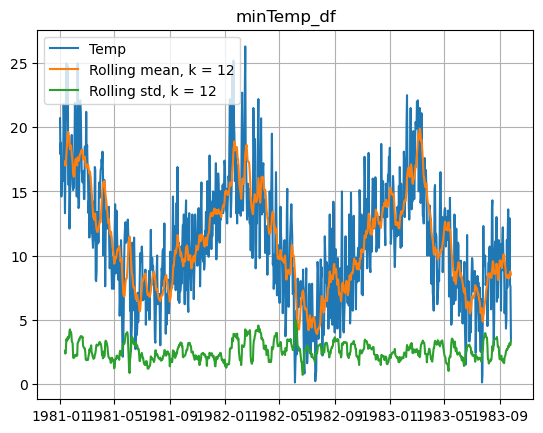

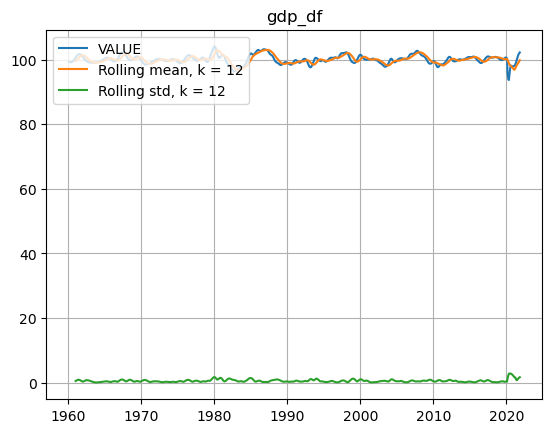

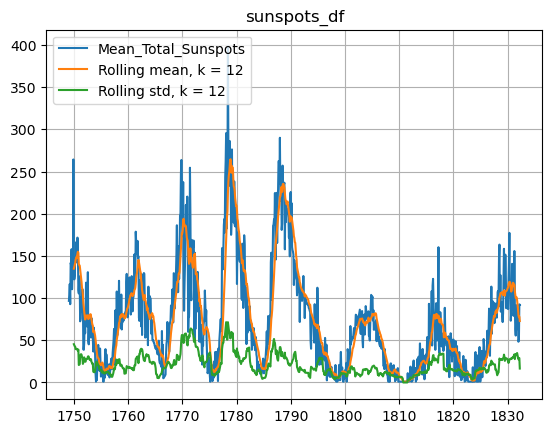

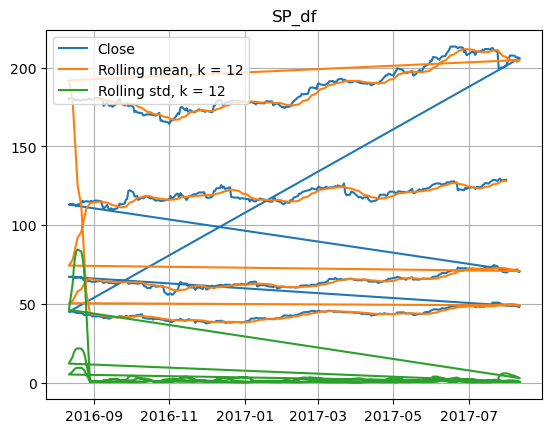

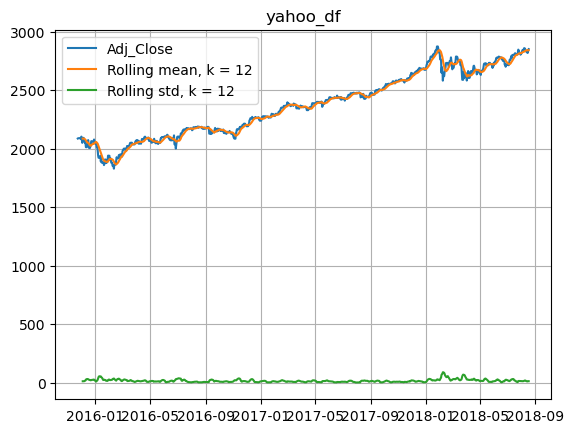

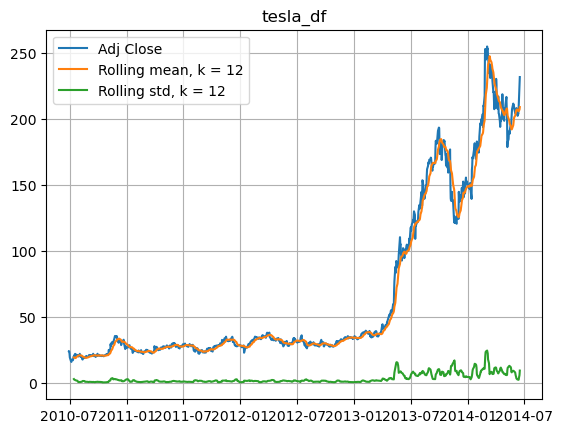

In [4]:
def mean_var_plot(dfs):
    for df in dfs:
        col = df[df.columns[1]]
        rolling_mean = col.rolling(window = 12).mean()
        rolling_std = col.rolling(window = 12).std()

        plt.plot(df[df.columns[0]], df[df.columns[1]],label = f'{df.columns[1]}')
        plt.plot(df[df.columns[0]], rolling_mean,label = f'Rolling mean, k = {12}')
        plt.plot(df[df.columns[0]], rolling_std,label = f'Rolling std, k = {12}')

        
        #plt.plot(col.rolling(window = int(len(col)), center = False).mean())
        #plt.plot(col.rolling(window = int(len(col)), center = False).std())
        plt.legend(loc = 'upper left')
        plt.title(f'{df.name}')
        plt.grid()
        plt.show()
        
mean_var_plot(dfs_list)

# Transform

In [5]:
def log_transform(dfs):
    transformed = []
    lambda_list = []
    for df in dfs:
        col_transformed = boxcox(df[df.columns[1]], 0)
        col_transformed = pd.DataFrame({'Date': df[df.columns[0]], f'{df.columns[1]}': col_transformed})
        transformed.append(col_transformed)
        lambda_list.append(0) 
    transformed = set_name(transformed, name_list)
    return transformed, lambda_list
 

In [6]:
log_transformed_list, best_lambdas = log_transform(dfs_list)


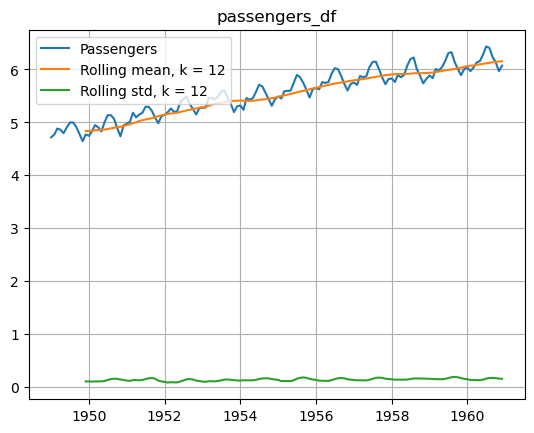

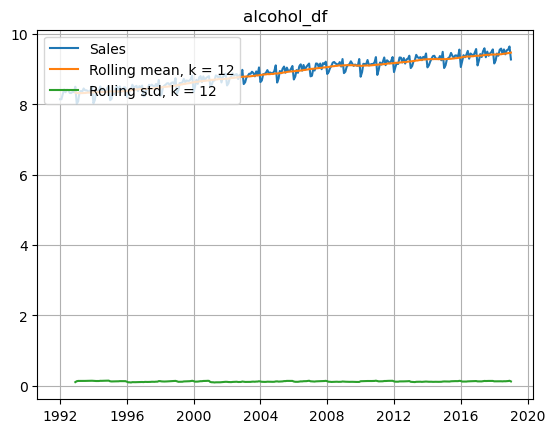

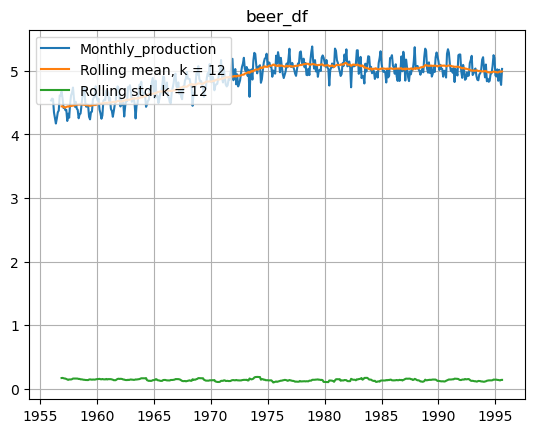

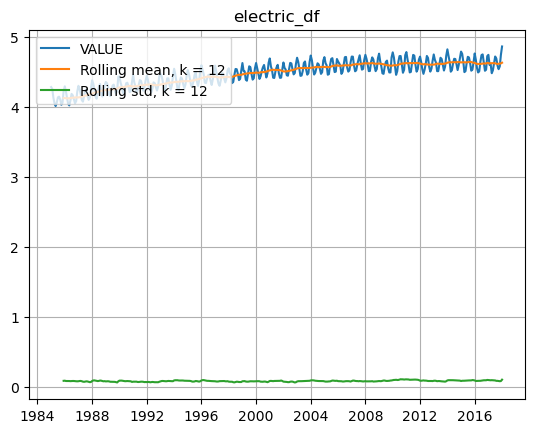

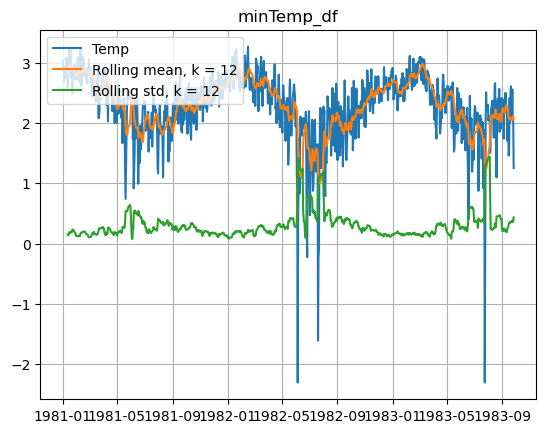

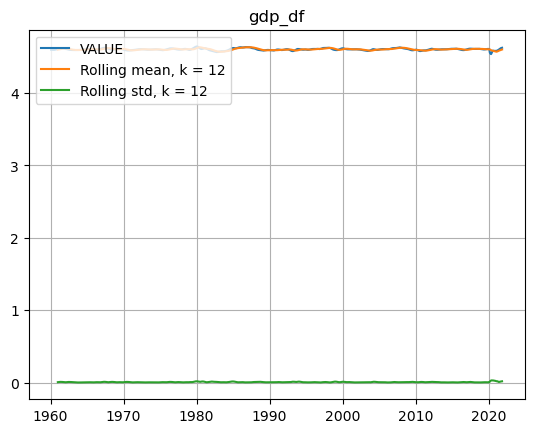

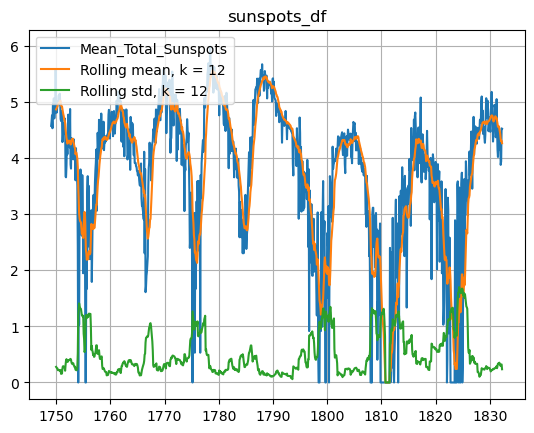

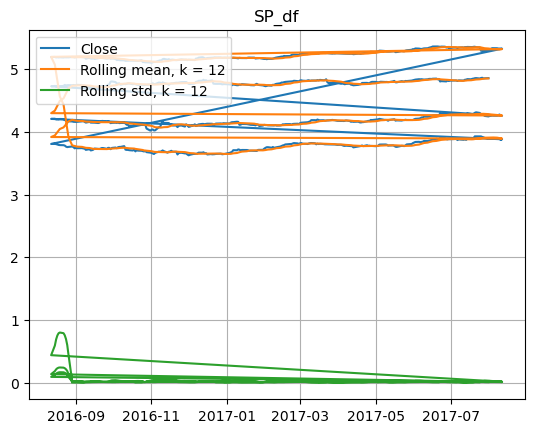

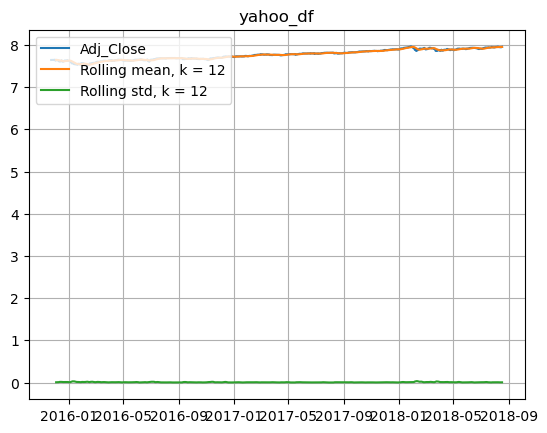

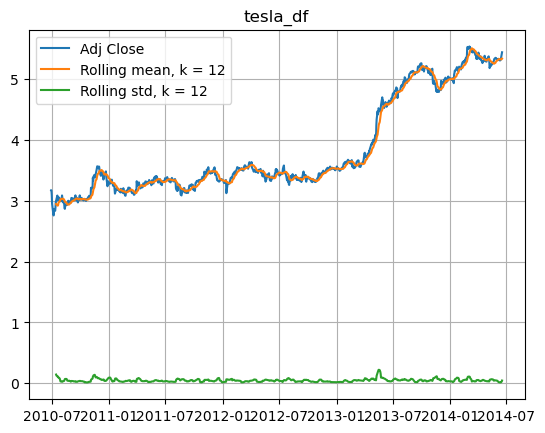

In [7]:
mean_var_plot(log_transformed_list)

# Stationarity tests
https://analyzingalpha.com/blog/check-time-series-stationarity-python
https://towardsdatascience.com/time-series-from-scratch-stationarity-tests-and-automation-14b02fa5ca4d

### Augmented Dickey-Fuller (ADF) and Kwiakowski-Phillips-Schmidt-Shin (KPSS) tests


In [8]:
# For an ADF-test, we assume the data is stationary if the p-value is below 0.05.
# The two functions below each returns assumed stationary and non-stationary dataframes in two lists.

def adf_test(dfs):
    print('ADF-test:')
    stationary_dfs, non_stationary_dfs = [], []
    for df in dfs:
        p_val = adfuller(df[df.columns[1]])[1]
        print(f'{df.name} P-value: {p_val}')

        if p_val < 0.05:
            stationary_dfs.append(df)
        else:
            non_stationary_dfs.append(df)
    
    print(f'assumed stationary dataframes: {[x.name for x in stationary_dfs]}')
    print(f'assumed non-stationary dataframes: {[x.name for x in non_stationary_dfs]}')
    print('---------------------------------------------------')
    return stationary_dfs, non_stationary_dfs



# For a KPSS-test, we assume the data is stationary if the p-value is above 0.05.
# Note that the return p-value is 0.1 if the actual p-value is greater or equal than 0.1, 
# and 0.01 if the actual p-value is equal or less than 0.01
def kpss_test(dfs):
    print('KPSS-test:')
    
    stationary_dfs, non_stationary_dfs = [], []
    for df in dfs:
        p_val = kpss(df[df.columns[1]], nlags = "auto")[1]
        print(f'{df.name} P-value: {p_val}')
    
        if p_val >= 0.05:
            stationary_dfs.append(df)
        else:
            non_stationary_dfs.append(df)
    
   
    print(f'assumed stationary dataframes: {[x.name for x in stationary_dfs]}')
    print(f'assumed non-stationary dataframes: {[x.name for x in non_stationary_dfs]}')       
    print('---------------------------------------------------')
    return stationary_dfs, non_stationary_dfs
    
#adf_stationary_dfs, adf_non_stationary_dfs = adf_test(log_transformed_list)
#kpss_stationary_dfs, kpss_non_stationary_dfs = kpss_test(log_transformed_list)

In [9]:
adf_stationary_dfs, adf_non_stationary_dfs = adf_test(dfs_list)

ADF-test:
passengers_df P-value: 0.991880243437641
alcohol_df P-value: 0.9987196267088919
beer_df P-value: 0.17762099829132272
electric_df P-value: 0.1862146911658677
minTemp_df P-value: 0.10465864097847721
gdp_df P-value: 2.343604538221738e-06
sunspots_df P-value: 2.125527915501042e-05
SP_df P-value: 0.3854343028881082
yahoo_df P-value: 0.9456178089543983
tesla_df P-value: 0.9842984289175463
assumed stationary dataframes: ['gdp_df', 'sunspots_df']
assumed non-stationary dataframes: ['passengers_df', 'alcohol_df', 'beer_df', 'electric_df', 'minTemp_df', 'SP_df', 'yahoo_df', 'tesla_df']
---------------------------------------------------


In [10]:
kpss_stationary_dfs, kpss_non_stationary_dfs = kpss_test(dfs_list)

KPSS-test:
passengers_df P-value: 0.01
alcohol_df P-value: 0.01
beer_df P-value: 0.01
electric_df P-value: 0.01
minTemp_df P-value: 0.0738247233732203
gdp_df P-value: 0.1
sunspots_df P-value: 0.01463693884227634
SP_df P-value: 0.01
yahoo_df P-value: 0.01
tesla_df P-value: 0.01
assumed stationary dataframes: ['minTemp_df', 'gdp_df']
assumed non-stationary dataframes: ['passengers_df', 'alcohol_df', 'beer_df', 'electric_df', 'sunspots_df', 'SP_df', 'yahoo_df', 'tesla_df']
---------------------------------------------------


# Inverse differencing and boxcox transformation

In [11]:
#from pmdarima.utils import diff_inv
'''
def inverse_difference(dfs, transformed):
    inversed_diff_list = []
    for i in range(0, len(dfs)):
        df = dfs[i]
        name = df.name
        df = df[df.columns[1]]
        trans = transformed[i]
        
       
        
        
        
        while len(df) != len(trans):
            df = np.r_[trans[trans.columns[1]][0], df].cumsum()
            print(f'{name} inverse differenciated')
            
        inversed_diff_list.append(df)
    return inversed_diff_list
        
        # reversed_df = np.r_[passengers_transformed[passengers_transformed.columns[0]][0], passengers_diffed[passengers_diffed.columns[0]]].cumsum()
inversed_differenced_list = inverse_difference(diffed_list, log_transformed_list)
'''

"\ndef inverse_difference(dfs, transformed):\n    inversed_diff_list = []\n    for i in range(0, len(dfs)):\n        df = dfs[i]\n        name = df.name\n        df = df[df.columns[1]]\n        trans = transformed[i]\n        \n       \n        \n        \n        \n        while len(df) != len(trans):\n            df = np.r_[trans[trans.columns[1]][0], df].cumsum()\n            print(f'{name} inverse differenciated')\n            \n        inversed_diff_list.append(df)\n    return inversed_diff_list\n        \n        # reversed_df = np.r_[passengers_transformed[passengers_transformed.columns[0]][0], passengers_diffed[passengers_diffed.columns[0]]].cumsum()\ninversed_differenced_list = inverse_difference(diffed_list, log_transformed_list)\n"

# Sesonal decompose

In [12]:
#sd = seasonal_decompose(passengers_df['Passengers'], freq = 12, model = 'multiplicative')
#sd.plot()